Epoch [1/1000], Loss: 20.0556
Epoch [100/1000], Loss: 4.3335
Epoch [200/1000], Loss: 4.3216
Epoch [300/1000], Loss: 4.3171
Epoch [400/1000], Loss: 4.3110
Epoch [500/1000], Loss: 4.3060
Epoch [600/1000], Loss: 4.2980
Epoch [700/1000], Loss: 4.3014
Epoch [800/1000], Loss: 4.3139
Epoch [900/1000], Loss: 4.2892
Epoch [1000/1000], Loss: 4.2933


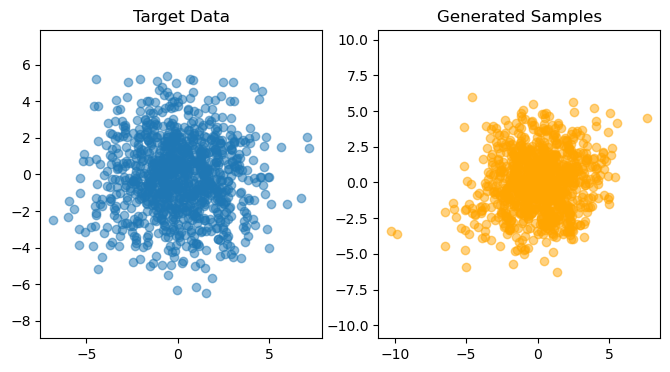

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal

# ----------------------------
# 1. 데이터 생성 (타겟 분포)
# ----------------------------
def generate_target_data(n_samples=1000):
    # 2D 원형 분포 (예: 원형 가우시안)
    mean = torch.zeros(2)
    cov = torch.eye(2) * 0.5
    distribution = MultivariateNormal(mean, cov)
    samples = distribution.sample((n_samples,))
    # 원형을 더 복잡하게 만들기 위해 비선형 변환 적용
    theta = 2 * torch.pi * torch.rand(n_samples)
    radius = torch.sqrt(samples[:, 0]**2 + samples[:, 1]**2) * 3
    x = radius * torch.cos(theta)
    y = radius * torch.sin(theta)
    return torch.stack([x, y], dim=1)

target_data = generate_target_data()

# ----------------------------
# 2. Affine Coupling Layer 구현
# ----------------------------
class AffineCoupling(nn.Module):
    def __init__(self, input_dim, hidden_dim, mask):
        super(AffineCoupling, self).__init__()
        self.mask = mask
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()  # 제한된 스케일 값을 위해 Tanh 사용
        )
        self.translate_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x):
        x_masked = x * self.mask
        s = self.scale_net(x_masked) * (1 - self.mask)
        t = self.translate_net(x_masked) * (1 - self.mask)
        y = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)
        log_det_jacobian = torch.sum(s, dim=1)
        return y, log_det_jacobian
    
    def inverse(self, y):
        y_masked = y * self.mask
        s = self.scale_net(y_masked) * (1 - self.mask)
        t = self.translate_net(y_masked) * (1 - self.mask)
        x = y_masked + (1 - self.mask) * ((y - t) * torch.exp(-s))
        log_det_jacobian = -torch.sum(s, dim=1)
        return x, log_det_jacobian

# ----------------------------
# 3. Flow Model 정의
# ----------------------------
class NormalizingFlow(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers):
        super(NormalizingFlow, self).__init__()
        self.layers = nn.ModuleList()
        # Alternate masks for coupling layers
        for i in range(n_layers):
            mask = torch.tensor([i % 2, (i + 1) % 2], dtype=torch.float32)
            self.layers.append(AffineCoupling(input_dim, hidden_dim, mask))
        # 최종 정규 분포 (표준 정규 분포)
        self.base_dist = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))
    
    def forward(self, x):
        log_det_jacobian = torch.zeros(x.shape[0])
        for layer in self.layers:
            x, ldj = layer(x)
            log_det_jacobian += ldj
        return x, log_det_jacobian
    
    def inverse(self, y):
        log_det_jacobian = torch.zeros(y.shape[0])
        for layer in reversed(self.layers):
            y, ldj = layer.inverse(y)
            log_det_jacobian += ldj
        return y, log_det_jacobian
    
    def log_prob(self, x):
        z, log_det_jacobian = self.forward(x)
        log_p_z = self.base_dist.log_prob(z)
        return log_p_z + log_det_jacobian

# ----------------------------
# 4. 학습
# ----------------------------
# 하이퍼파라미터 설정
input_dim = 2
hidden_dim = 256
n_layers = 6
learning_rate = 1e-3
batch_size = 256
epochs = 1000

# 모델, 옵티마이저 정의
model = NormalizingFlow(input_dim, hidden_dim, n_layers)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 데이터 로더
dataset = torch.utils.data.TensorDataset(target_data)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 학습 루프
for epoch in range(epochs):
    total_loss = 0
    for batch in data_loader:
        x = batch[0]
        optimizer.zero_grad()
        loss = -model.log_prob(x).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    avg_loss = total_loss / len(dataset)
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# ----------------------------
# 5. 결과 시각화
# ----------------------------
# 샘플링
with torch.no_grad():
    z = model.base_dist.sample((1000,))
    samples, _ = model.inverse(z)

# 타겟 데이터와 생성된 샘플 시각화
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Target Data")
plt.scatter(target_data[:, 0].numpy(), target_data[:, 1].numpy(), alpha=0.5)
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.title("Generated Samples")
plt.scatter(samples[:, 0].numpy(), samples[:, 1].numpy(), alpha=0.5, color='orange')
plt.axis('equal')

SAVE_PLT = True 
if SAVE_PLT:
    plt.savefig('../.github/assets/normalizing_flow.png')
else:
    plt.show()